In [1]:
from pathlib import Path

seagate = '/run/media/anton/Seagate Portable Drive'
fmriprep = f'{seagate}/PNC_Test_Out'

outsubs = []

for item in Path(fmriprep).iterdir():
    if item.is_dir() and item.name[:3] == 'sub':
        outsubs.append(item.name)
        
print(len(outsubs))

946


In [2]:
tar = f'{seagate}/PNC_tarFiles'

missingsubs = []

for item in Path(tar).iterdir():
    sub = 'sub-' + item.name.split('_')[0]
    if sub not in outsubs:
        missingsubs.append(sub)
        
print(len(missingsubs))

49


In [3]:
import os.path

emoidsubs = []
nbacksubs = []
restsubs = []

for sub in outsubs:
    fmridir = f'{fmriprep}/{sub}/func'
    for task,arr in zip(['emoid','rest','nback'],[emoidsubs,restsubs,nbacksubs]):
        fname = f'{fmridir}/{sub}_task-{task}_rec-uncorrected_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
        if os.path.exists(fname):
            arr.append(sub)
            
print(len(emoidsubs))
print(len(nbacksubs))
print(len(restsubs))

928
907
877


In [28]:
import pickle

meta = None

with open('/home/anton/Documents/Tulane/Research/PNC_Good/MegaMeta3.pkl', 'rb') as f:
    meta = pickle.load(f)
    
print(len(list(meta.keys())))

941


In [30]:
print(len([key for key in meta.keys() if 'emoid' in meta[key]]))
print(len([key for key in meta.keys() if 'nback' in meta[key]]))
print(len([key for key in meta.keys() if 'rest' in meta[key]]))

678
907
873


In [4]:
import numpy as np
from nilearn import image

# Load power template coords
powerfile = '/home/anton/Documents/Tulane/Hackathon/power264/power264MNI.nii.gz'

powerimg = image.load_img(powerfile)
datpower = image.get_data(powerimg)

print(datpower.shape)

(91, 109, 91)


In [5]:
# Sort power coordinates

pcoords = []
proinums = []

for roi in range(264):
    x,y,z = np.where(datpower == roi+1)
    pcoords.append(np.stack([x,y,z,np.ones(x.shape[0])]).T)
    proinums.append(roi*np.ones(x.shape[0]))
    
pcoords = np.concatenate(pcoords).T
proinums = np.concatenate(proinums)

print(pcoords.shape)
print(proinums.shape)

(4, 21384)
(21384,)


In [6]:
from scipy.interpolate import interpn

tsdict = dict(emoid={}, nback={}, rest={})

# Concern subjects (first 2) and QC fails for rest (last 3)
# emoidsubs = [
#     'sub-607602498818','sub-608007693853','sub-603403163265','sub-605515760919','sub-600210241146'
# ]
# nbacksubs = emoidsubs
# restsubs = nbacksubs

for task,taskarr in zip(['emoid', 'nback', 'rest'], [emoidsubs,nbacksubs,restsubs]):
    for i,sub in enumerate(taskarr):
        if i % 20 == 0:
            print(f'Running {task} {i} {sub}')
        
        fmridir = f'{fmriprep}/{sub}/func'
        imgname = fname = f'{fmridir}/{sub}_task-{task}_rec-uncorrected_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
        img = image.load_img(imgname)
        datimg = image.get_data(img)
        
        coords = np.linalg.inv(img.affine)@powerimg.affine@pcoords
        points = [np.arange(s) for s in img.shape[:-1]]
        
        nt = datimg.shape[-1]
        ts = np.zeros((264,nt))
        res = np.zeros((nt,coords.shape[-1]))

        for tp in range(nt):
            res[tp] = interpn(points, datimg[:,:,:,tp], coords[:-1].T, bounds_error=False)

        for roi in range(264):
            ts[roi] = np.mean(res[:,proinums == roi], axis=1)
            
        tsdict[task][sub] = ts

Running emoid 0 sub-600009963128
Running emoid 20 sub-601098855033
Running emoid 40 sub-600896033967
Running emoid 60 sub-601421468675
Running emoid 80 sub-601667746830
Running emoid 100 sub-601983541597
Running emoid 120 sub-602260470547
Running emoid 140 sub-602428968376
Running emoid 160 sub-602784676967
Running emoid 180 sub-603029229426
Running emoid 200 sub-603279373656
Running emoid 220 sub-603441403158
Running emoid 240 sub-603672020440
Running emoid 260 sub-603854632982
Running emoid 280 sub-603192992915
Running emoid 300 sub-604270707793
Running emoid 320 sub-604527984573
Running emoid 340 sub-604718130562
Running emoid 360 sub-604921668926
Running emoid 380 sub-605153438249
Running emoid 400 sub-605481196229
Running emoid 420 sub-604740287921
Running emoid 440 sub-605792122916
Running emoid 460 sub-606031229906
Running emoid 480 sub-606213296175
Running emoid 500 sub-606441281285
Running emoid 520 sub-606720913120
Running emoid 540 sub-606917773803
Running emoid 560 sub-6025

In [7]:
tsdict2 = dict(emoid={}, nback={}, rest={})

for task in ['emoid', 'nback', 'rest']:
    for sub in tsdict[task]:
        tsdict2[task][sub] = tsdict[task][sub].astype('float32')
        
print('Complete')

Complete


In [11]:
import pickle

tsdictname = f'{seagate}/PNC_PowerTS_float2.pkl'

with open(tsdictname, 'wb') as f:
    pickle.dump(tsdict2, f)
    
print('Complete')

Complete


In [10]:
for sub,rest in tsdict2['nback'].items():
    p = np.corrcoef(rest)
    if np.sum(np.isnan(p)) > 0:
        print(sub)

In [15]:
from scipy import signal
import random

def butter_bandpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = [cutoff[0] / nyq, cutoff[1] / nyq]
    b, a = signal.butter(order, normal_cutoff, btype='band', analog=False)
    return b, a

def butter_bandpass_filter(data, cutoff, fs, order=5):
    b, a = butter_bandpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

ts = tsdict2['rest']['sub-600682103788']

tr = 1.83
N = ts.shape[-1]

filt_ts = butter_bandpass_filter(ts, [tr/20*N, 0.8*N], 2*N)

# mu = np.mean(filt_ts, axis=1, keepdims=True)
# sigma = np.std(filt_ts, axis=1, keepdims=True)

# filt_ts = (filt_ts-mu)/sigma

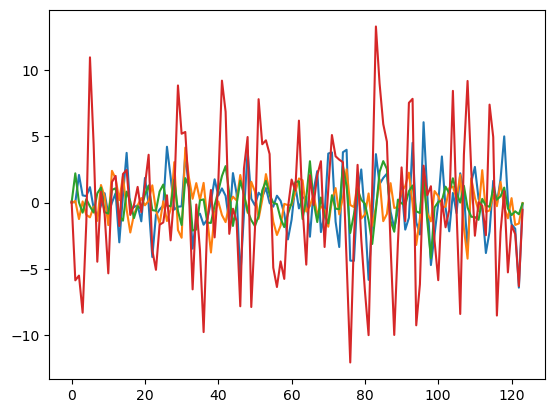

In [16]:
import matplotlib.pyplot as plt

plt.plot(filt_ts[0])
plt.plot(filt_ts[4])
plt.plot(filt_ts[10])
plt.plot(filt_ts[100])
plt.show()

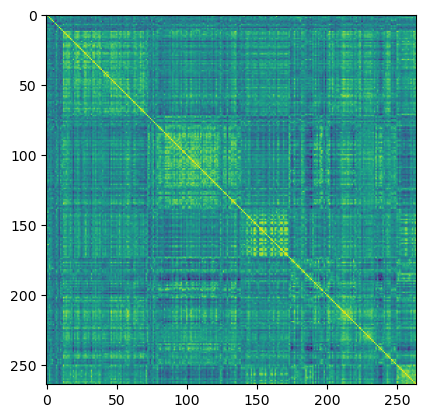

In [17]:
import matplotlib.pyplot as plt

p = np.corrcoef(filt_ts)
plt.imshow(p)
plt.show()